In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Download Tensorflow

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

## Again start by downloading the neccessary data into the Colab Instance
We will split our dataset into three subsets: training set, validation set and testing set.

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

DATASET_DIR = '/content/dataset/'

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    data_dir=DATASET_DIR,
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    shuffle_files=True, 
    as_supervised=True,
)

# tf.data.experimental.cardinality(raw_train_dataset).numpy()
num_examples = metadata.splits['train'].num_examples
num_classes = metadata.features['label'].num_classes
print("Numbers of images: ", num_examples)
print("Numbers of classes: ", num_classes)

Shuffling and writing examples to /content/dataset/cats_vs_dogs/4.0.0.incompleteKF6LC5/cats_vs_dogs-train.tfrecord


Dataset cats_vs_dogs downloaded and prepared to /content/dataset/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
Numbers of images:  23262
Numbers of classes:  2


##Now when we organize the data into Wrappers note how we use many more kinds of Data Augmentation.

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np

BATCH_SIZE = 32
IMAGE_SIZE = 224
AUTOTUNE = tf.data.AUTOTUNE

def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE)) / 255.0
    return  image, label

# Add augmentations
def flip(x):
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)
    return x

def color(x):
    x = tf.image.random_hue(x, 0.08)
    x = tf.image.random_saturation(x, 0.6, 1.6)
    x = tf.image.random_brightness(x, 0.05)
    x = tf.image.random_contrast(x, 0.7, 1.3)
    return x

def rotate(x):
    x = tf.image.rot90(x, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    return x

def zoom(x):
    # Generate 20 crop settings, ranging from a 1% to 20% crop.
    scales = list(np.arange(0.8, 1.0, 0.01))
    boxes = np.zeros((len(scales), 4))

    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]

    def random_crop(img):
        # Create different crops for an image
        crops = tf.image.crop_and_resize([img], boxes=boxes, box_indices=np.zeros(len(scales)), crop_size=(IMAGE_SIZE,IMAGE_SIZE))
        # Return a random crop
        return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]
    choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)
    # Only apply cropping 50% of the time
    x = tf.cond(choice < 0.5, lambda: x, lambda: random_crop(x))
    return x

def data_augment(x, label, augmentations = [flip, color, zoom, rotate]):
    for f in augmentations:
        x = tf.cond(tf.random.uniform([], 0, 1) > 0.75, lambda: f(x), lambda: x)
    x = tf.clip_by_value(x, 0, 1)
    return x, label


train_batches = raw_train.shuffle(num_examples // 4).map(format_image,num_parallel_calls=AUTOTUNE)
train_batches = train_batches.map(data_augment, num_parallel_calls=AUTOTUNE)
train_batches = train_batches.batch(BATCH_SIZE).prefetch(AUTOTUNE)

validation_batches = raw_validation.map(format_image,num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_batches = raw_test.map(format_image).batch(1)


## Define your model and optimizer

In [ ]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    # Output neuron
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
print(model.summary())

from tensorflow.keras.optimizers import RMSprop
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 24, 24, 64)       

## Train your model
This may take a little while. Take a break ! Since we now have more data due to the data augmentation this training process will take a bit longer than the last time. Are the results better ?

In [ ]:
history = model.fit(
      train_batches,  
      epochs=20, 
      validation_data=validation_batches)

Epoch 1/20
582/582 [==============================] - 98s 110ms/step - loss: 0.6757 - acc: 0.5847 - val_loss: 0.5676 - val_acc: 0.7309
Epoch 2/20
582/582 [==============================] - 67s 109ms/step - loss: 0.5721 - acc: 0.7021 - val_loss: 0.5140 - val_acc: 0.7485
Epoch 3/20
582/582 [==============================] - 67s 109ms/step - loss: 0.5256 - acc: 0.7407 - val_loss: 0.5154 - val_acc: 0.7567
Epoch 4/20
582/582 [==============================] - 67s 108ms/step - loss: 0.4847 - acc: 0.7696 - val_loss: 0.4891 - val_acc: 0.7623
Epoch 5/20
582/582 [==============================] - 67s 108ms/step - loss: 0.4535 - acc: 0.7974 - val_loss: 0.4697 - val_acc: 0.7833
Epoch 6/20
582/582 [==============================] - 68s 111ms/step - loss: 0.4255 - acc: 0.8009 - val_loss: 0.4121 - val_acc: 0.8366
Epoch 7/20
582/582 [==============================] - 67s 108ms/step - loss: 0.3994 - acc: 0.8214 - val_loss: 0.4018 - val_acc: 0.8130
Epoch 8/20
582/582 [==============================] - 6

## Plotting the training process
We plot the loss and accurracy of the training process with respect to the training set and the validation set

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


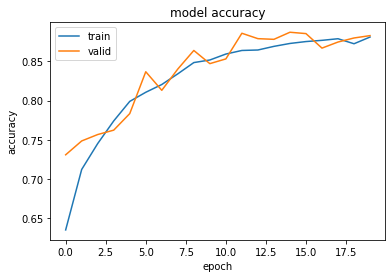

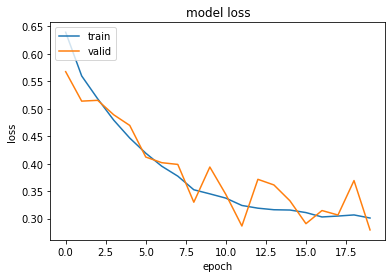

In [ ]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

## Run your Model

Let's now take a look at actually running a prediction using the model. This code will test 100 images from the testing set

In [ ]:
from tqdm import tqdm
import numpy as np

predictions = []

# This will report how many iterations per second, where each
# iteration is 100 predictions
test_labels, test_imgs = [], []
for img, label in tqdm(test_batches.take(100)):
    predictions.append(model.predict(img))
    
    test_labels.append(label.numpy()[0])
    test_imgs.append(img)


# This will tell you how many of the predictions were correct
score = 0
for item in range(0,len(predictions)):
  prediction=np.argmax(predictions[item])
  label = test_labels[item]
  if prediction==label:
    score=score+1

print("Out of 100 predictions I got " + str(score) + " correct")

100%|██████████| 100/100 [00:03<00:00, 25.62it/s]

Out of 100 predictions I got 86 correct


## Clean Up

Before running the next exercise, run the following cell to terminate the kernel and free memory resources:

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)

##Exercice

Let's add other types of data augmentation to assess the performance, such as:


* tf.image.stateless_random_brightness
* tf.image.stateless_random_contrast
* tf.image.stateless_random_crop
* tf.image.stateless_random_saturation
* tf.image.stateless_random_flip_left_right
* ...

